<h1 style="text-align: center">Portland Land Surface Temperature Analysis</h1>

---

Each 16-bit pixel value that has a value range up to 65535 intensities, represents 1 km² on the surface.

*Note: these granules are for day time.*

In [1]:
# Data Manipulation
import h5py
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2

# File System
import os
from pathlib import Path
import sys
sys.path.append('.')

# Custom Libraries
from portland_uhi_analysis import PortlandHeatAnalyzer, create_comparison_visualizations

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.style.use('default')
%matplotlib inline

## Initial HDF5 File Parsing

In [2]:
data_path = Path(r"VNP21A1D_002-20260121_000233")

h5_files = sorted(list(data_path.glob("*.h5")))

print(f"Found {len(h5_files)} HDF5 files")
print(f"\nFirst 5 files:")
for f in h5_files[:5]:
    print(f"  {f.name}")
print(f"\nLast 5 files:")
for f in h5_files[-5:]:
    print(f"  {f.name}")

Found 89 HDF5 files

First 5 files:
  VNP21A1D.A2025152.h09v04.002.2025153135916.h5
  VNP21A1D.A2025153.h09v04.002.2025154133309.h5
  VNP21A1D.A2025154.h09v04.002.2025155125449.h5
  VNP21A1D.A2025155.h09v04.002.2025156132530.h5
  VNP21A1D.A2025156.h09v04.002.2025157134932.h5

Last 5 files:
  VNP21A1D.A2025239.h09v04.002.2025242044759.h5
  VNP21A1D.A2025240.h09v04.002.2025242052514.h5
  VNP21A1D.A2025241.h09v04.002.2025242162925.h5
  VNP21A1D.A2025242.h09v04.002.2025243134446.h5
  VNP21A1D.A2025243.h09v04.002.2025244164416.h5


Now to extract the metadata from the VIIRS HDF5 to understand the file naming convention set by NASA.

In [3]:
def parse_viirs_filename(filename: str) -> dict:
    """
    Parse VIIRS filename to extract metadata including product type, acquisition 
    date, tile coordinates, version, and production timestamp.
    """
    parts = filename.replace('.h5', '').split('.')
    
    # Product identifier (e.g., VNP21A1D = VIIRS/NPP LST Daily)
    product = parts[0]
    
    # Parse acquisition date in Julian format (AYYYYDDD format)
    date_str = parts[1]  # A2025166
    year = int(date_str[1:5])
    day_of_year = int(date_str[5:])
    acquisition_date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
    
    # Sinusoidal grid tile identifier (hXXvYY format)
    tile = parts[2]  # h09v04
    h_tile = int(tile[1:3]) # horizontal tile number
    v_tile = int(tile[4:6]) # vertical tile number
    
    # Collection/processing version number
    version = parts[3]  # 002
    
    # Production datetime stamp (YYYYDDDHHMMSS format)
    production_datetime = parts[4]  # 2025168061605
    
    return {
        'product': product,
        'acquisition_date': acquisition_date,
        'year': year,
        'day_of_year': day_of_year,
        'tile': tile,
        'h_tile': h_tile,
        'v_tile': v_tile,
        'version': version,
        'production_datetime': production_datetime
    }

# Test the parsing function with the first file in the dataset
sample_file = h5_files[0]
file_info = parse_viirs_filename(sample_file.name)

print(f"\nFilename: {sample_file.name}")
print(f"\nDecoded information:")
for key, value in file_info.items():
    print(f"  {key:20}: {value}") # left-align keys in 20-char field


Filename: VNP21A1D.A2025152.h09v04.002.2025153135916.h5

Decoded information:
  product             : VNP21A1D
  acquisition_date    : 2025-06-01 00:00:00
  year                : 2025
  day_of_year         : 152
  tile                : h09v04
  h_tile              : 9
  v_tile              : 4
  version             : 002
  production_datetime : 2025153135916


In [4]:
# Create a summary of all files
file_summary = []
for f in h5_files:
    info = parse_viirs_filename(f.name)
    info['filename'] = f.name
    info['size_MB'] = f.stat().st_size / (1024 * 1024)
    file_summary.append(info)

df_files = pd.DataFrame(file_summary)

print(f"\nDate range: {df_files['acquisition_date'].min()} to {df_files['acquisition_date'].max()}")
print(f"Unique tiles: {df_files['tile'].unique()}")
print(f"Total files: {len(df_files)}")
print(f"Total size: {df_files['size_MB'].sum():.2f} MB")
print(f"\nFiles per tile:")
print(df_files['tile'].value_counts())


Date range: 2025-06-01 00:00:00 to 2025-08-31 00:00:00
Unique tiles: ['h09v04']
Total files: 89
Total size: 210.51 MB

Files per tile:
tile
h09v04    89
Name: count, dtype: int64


## HDF5 Data Layout

An HDF5 can be thought of as a hybrid file/directory format that contains an organizational system of datasets and various file types, all within this portable file system. This makes it perfect for sending enormous amounts of categorized data from satellites to ground based servers.

In [27]:
def explore_hdf5(file_path: str) -> None:
    """
    Recursively explore and print the hierarchical structure of an HDF5 file,
    displaying groups, datasets, and dataset metadata (shape and dtype).
    """
    def print_structure(name: str, obj) -> None:
        """Callback function invoked by visititems() for each group/dataset."""
        # Calculate indentation based on nesting depth (count of '/' in path)
        indent = "  " * name.count('/')
        if isinstance(obj, h5py.Group):
            print(f"{indent} GROUP: {name}")
        elif isinstance(obj, h5py.Dataset):
            # For datasets, also display shape and data type information
            print(f"{indent}    DATASET: {name}")
            print(f"{indent}    Shape: {obj.shape}")
            print(f"{indent}    Dtype: {obj.dtype}")
    
    with h5py.File(file_path, 'r') as f:
        f.visititems(print_structure)

# Explore first file
explore_hdf5(h5_files[0])

 GROUP: HDFEOS
   GROUP: HDFEOS/ADDITIONAL
     GROUP: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES
   GROUP: HDFEOS/GRIDS
     GROUP: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21
       GROUP: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields
            DATASET: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields/Emis_14
            Shape: (1200, 1200)
            Dtype: uint8
            DATASET: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields/Emis_15
            Shape: (1200, 1200)
            Dtype: uint8
            DATASET: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields/Emis_16
            Shape: (1200, 1200)
            Dtype: uint8
            DATASET: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields/LST_1KM
            Shape: (1200, 1200)
            Dtype: uint16
            DATASET: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields/Projection
            Shape: (1,)
            Dtype: int32
            DATASET: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields/QC
        

```html
📁 ROOT
├── 📁 HDFEOS
│   ├── 📁 ADDITIONAL
│   │   └── 📁 FILE_ATTRIBUTES (general file info)
│   │
│   └── 📁 GRIDS
│       └── 📁 VIIRS_Grid_Daily_1km_LST21
│           │
│           ├──  XDim (1200,) ─────────── X coordinates in meters
│           ├──  YDim (1200,) ─────────── Y coordinates in meters
│           │
│           └── 📁 Data Fields
│               ├──  LST_1KM ──────────── THE TEMPERATURE DATA (main dataset)
│               ├──  QC ───────────────── Quality control flags
│               ├──  Emis_14 ──────────── Emissivity band 14
│               ├──  Emis_15 ──────────── Emissivity band 15
│               ├──  Emis_16 ──────────── Emissivity band 16
│               ├──  View_Angle ───────── Satellite viewing angle
│               ├──  View_Time ────────── Time of observation
│               └──  Projection ───────── Map projection info
│
└── 📁 HDFEOS INFORMATION
    └──  StructMetadata.0 ─────────────── Technical metadata
```

HDF5 files contain rich metadata as "attributes". These tell us scale factors, units, and more.

In [6]:
def get_all_attributes(file_path: str) -> dict:
    """
    Extract all metadata attributes from an HDF5 file, including root-level
    attributes and attributes attached to each dataset.
    """
    attributes = {}
    
    with h5py.File(file_path, 'r') as f:
        # Root attributes
        attributes['ROOT'] = dict(f.attrs)
        
        # Dataset attributes
        def collect_attrs(name, obj):
            """Callback to collect attributes from each dataset in the file."""
            if isinstance(obj, h5py.Dataset):
                attributes[name] = dict(obj.attrs)
        
        # Traverse all objects and collect dataset attributes
        f.visititems(collect_attrs)
    
    return attributes

all_attrs = get_all_attributes(h5_files[0])

for key, value in list(all_attrs['ROOT'].items())[:20]:
    # Decode byte strings to UTF-8 for readable output
    if isinstance(value, bytes):
        value = value.decode('utf-8')
    print(f"  {key}: {value}")
print(f"\n  ... and {len(all_attrs['ROOT']) - 20} more attributes")

  AdditionalLayers: [9]
  AlgorithmType: SCI
  AlgorithmVersion: NPP_PRMGPNTR 1.5.07.03
  CharacteristicBinAngularSize: [30.]
  CharacteristicBinSize: [926.62543306]
  Conventions: CF-1.6
  CoverageCalculationMethod: volume
  CoverageMinimum: [0.01]
  DataColumns: [1200]
  DataResolution: 1km
  DataRows: [1200]
  DayNightFlag: Day
  DeepOceanFlag: Yes
  EastBoundingCoord: [-104.42170474]
  EndTime: 2025-06-01 23:59:59
  FirstLayerSelectionCriteria: order of input pointer
  GRingLatitude: [39.73423082 49.9394188  50.11591783 39.86238902]
  GRingLongitude: [-117.74644598 -140.79523467 -124.61534924 -104.23544582]
  GRingSequence: [1 2 3 4]
  GeoAnyAbnormal: False

  ... and 74 more attributes


Now to actually find all LST datasets within the HDF5 structure to display its metadata attributes needed for proper interpretation.

In [7]:
with h5py.File(h5_files[0], 'r') as f:
    lst_path = None
    def find_lst(name, obj):
        """Callback to locate the first dataset containing 'LST' in its path."""
        global lst_path
        if 'LST' in name and isinstance(obj, h5py.Dataset):
            lst_path = name
    
    # Search through file structure to find LST dataset
    f.visititems(find_lst)
    
    if lst_path:
        lst_dataset = f[lst_path]
        print(f"\nDataset path: {lst_path}")
        print(f"Shape: {lst_dataset.shape}")
        print(f"Data type: {lst_dataset.dtype}")
        print(f"\nAttributes:")
        for key, value in lst_dataset.attrs.items():
            if isinstance(value, bytes):
                value = value.decode('utf-8')
            elif isinstance(value, np.ndarray): # convert NumPy arrays to Python lists for cleaner displa
                value = value.tolist()
            print(f"  {key}: {value}")


Dataset path: HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/YDim
Shape: (1200,)
Data type: float64

Attributes:
  CLASS: DIMENSION_SCALE
  NAME: YDim
  REFERENCE_LIST: [(<HDF5 object reference>, 0), (<HDF5 object reference>, 0), (<HDF5 object reference>, 0), (<HDF5 object reference>, 0), (<HDF5 object reference>, 0), (<HDF5 object reference>, 0), (<HDF5 object reference>, 0)]
  long_name: y coordinate of projection
  standard_name: projection_y_coordinate
  units: m


Now let's actually read the temperature data and apply the scale factor.

In [8]:
def load_lst_data(
    file_path: str, 
    convert_to_celsius: bool = True
) -> tuple:
    """
    Load and process LST data from a VIIRS HDF5 file, applying scale factors
    and optional Kelvin-to-Celsius conversion. Returns masked array and metadata.
    """
    with h5py.File(file_path, 'r') as f:
        lst_path = 'HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields/LST_1KM'
        lst_dataset = f[lst_path]
        raw_data = lst_dataset[:]
        
        # Extract scale factor (converts raw integers to Kelvin)
        scale_factor = lst_dataset.attrs.get('scale_factor', 0.02)
        if isinstance(scale_factor, np.ndarray):
            scale_factor = scale_factor[0]
        
        # Extract add offset (0 for LST data)
        add_offset = lst_dataset.attrs.get('add_offset', 0)
        if isinstance(add_offset, np.ndarray):
            add_offset = add_offset[0]
        
        # Extract fill value used to mark missing/invalid pixels
        fill_value = lst_dataset.attrs.get('_FillValue', 0)
        if isinstance(fill_value, np.ndarray):
            fill_value = fill_value[0]
        
        # Extract valid data range bounds
        valid_min = lst_dataset.attrs.get('valid_min', 7500)
        valid_max = lst_dataset.attrs.get('valid_max', 65535)
        
        # Compile metadata dictionary for reference
        metadata = {
            'scale_factor': scale_factor,
            'add_offset': add_offset,
            'fill_value': fill_value,
            'valid_min': valid_min,
            'valid_max': valid_max,
            'shape': raw_data.shape,
            'dtype': str(raw_data.dtype)
        }
        
        # Create masked array (mask fill values and invalid data)
        mask = (raw_data == fill_value) | (raw_data == 0)
        lst_masked = np.ma.masked_array(raw_data, mask=mask)
        
        # Apply calibration: raw_value * scale_factor + offset = Kelvin
        lst_kelvin = lst_masked * scale_factor + add_offset
        
        # Option to convert from Kelvin to Celsius
        if convert_to_celsius:
            lst_data = lst_kelvin - 273.15
            metadata['units'] = 'Celsius'
        else:
            lst_data = lst_kelvin
            metadata['units'] = 'Kelvin'
    
    return lst_data, metadata

lst_data, metadata = load_lst_data(h5_files[0])

print(f"\nMetadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

print(f"\nData shape: {lst_data.shape}")
print(f"Data type: {lst_data.dtype}")
print(f"Valid pixels: {lst_data.count()} / {lst_data.size} ({100*lst_data.count()/lst_data.size:.1f}%)")
print(f"Masked pixels: {np.sum(lst_data.mask)} ({100*np.sum(lst_data.mask)/lst_data.size:.1f}%)")


Metadata:
  scale_factor: 0.02
  add_offset: 0.0
  fill_value: 0
  valid_min: 7500
  valid_max: 65535
  shape: (1200, 1200)
  dtype: uint16
  units: Celsius

Data shape: (1200, 1200)
Data type: float64
Valid pixels: 695393 / 1440000 (48.3%)
Masked pixels: 744607 (51.7%)


**Conversion Formula**

```html
Raw value: 15000 (uint16)
     ↓
× scale_factor (0.02)
     ↓
= 300 Kelvin
     ↓
- 273.15
     ↓
= 26.85°C  ← Actual temperature
```

The scale factor is a compression trick used by NASA to store integers instead of floats, then simply multiply by 0.02 to convert the raw pixel value (out of 65,535 values) to precise float-based temperature values. This way each sqaure kilometer on the planet can be recorded using integers instead of floats to drastically cut down on memory and storage.

Minimum: 0 × 0.02 = 0 K (but realistically starts ~7500)

Maximum: 65,535 × 0.02 = 1,310.7 K

Realistic range used:
* 7,500 × 0.02 = 150 K = -123°C (coldest possible, Antarctica)
* 17,500 × 0.02 = 350 K = +77°C (hottest land surface, deserts)

## Basic Statistics

In [9]:
def compute_statistics(data: np.ma.MaskedArray) -> dict:
    """
    Compute descriptive statistics for LST data, including measures 
    of central tendency, dispersion, and distribution shape.
    """
    # Extract flattened 1D array containing only the valid (non-masked) pixel values so that missing values does not skew calculations
    valid_data = data.compressed()
    
    stats = {
        'count: total valid pixels = total km² with good data': len(valid_data),
        'mean': np.mean(valid_data),
        'median': np.median(valid_data),
        'std': np.std(valid_data),
        'min': np.min(valid_data),
        'max': np.max(valid_data),
        'range': np.max(valid_data) - np.min(valid_data),
        'q25': np.percentile(valid_data, 25),
        'q75': np.percentile(valid_data, 75),
        'iqr': np.percentile(valid_data, 75) - np.percentile(valid_data, 25),
        'skewness': float(pd.Series(valid_data).skew()),
        'kurtosis': float(pd.Series(valid_data).kurtosis())
    }
    
    return stats

stats = compute_statistics(lst_data)

print(f"\n{'Statistic':<20} {'Value':>15}")
print("-" * 35)
for key, value in stats.items():
    if isinstance(value, float):
        print(f"{key:<20} {value:>15.2f}")
    else:
        print(f"{key:<20} {value:>15,}")


Statistic                      Value
-----------------------------------
count: total valid pixels = total km² with good data         695,393
mean                           33.30
median                         33.95
std                            11.80
min                           -30.45
max                            64.67
range                          95.12
q25                            23.29
q75                            43.15
iqr                            19.86
skewness                       -0.15
kurtosis                       -0.73


## Data Visualization

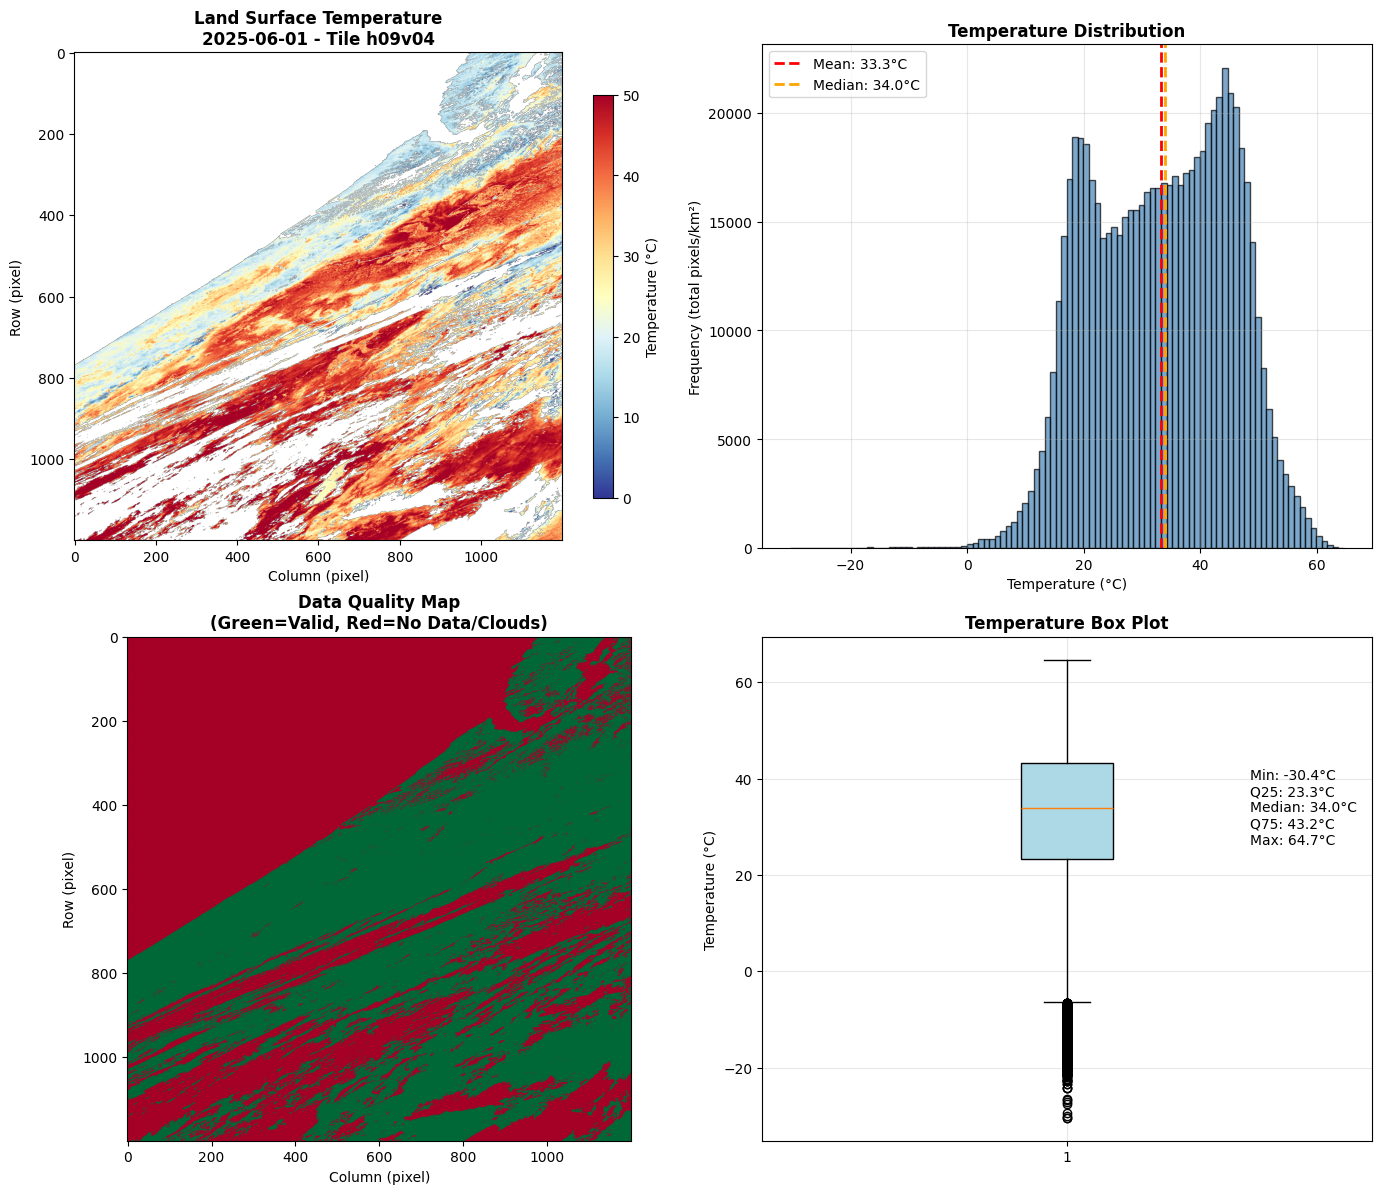


Figure saved as 'lst_initial_exploration.png'


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
file_info = parse_viirs_filename(h5_files[0].name)

# LST Heat Map
ax1 = axes[0, 0]
im1 = ax1.imshow(lst_data, cmap='RdYlBu_r', vmin=0, vmax=50)
ax1.set_title(f'Land Surface Temperature\n{file_info["acquisition_date"].strftime("%Y-%m-%d")} - Tile {file_info["tile"]}', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Column (pixel)')
ax1.set_ylabel('Row (pixel)')
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Temperature (°C)')

# Histogram
ax2 = axes[0, 1]
valid_data = lst_data.compressed()
ax2.hist(valid_data, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(stats['mean'], color='red', linestyle='--', linewidth=2, label=f'Mean: {stats["mean"]:.1f}°C')
ax2.axvline(stats['median'], color='orange', linestyle='--', linewidth=2, label=f'Median: {stats["median"]:.1f}°C')
ax2.set_title('Temperature Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Frequency (total pixels/km²)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Data Quality Map (showing masked vs valid)
ax3 = axes[1, 0]
quality_map = np.where(lst_data.mask, 0, 1)  # 0 = masked, 1 = valid
im3 = ax3.imshow(quality_map, cmap='RdYlGn', vmin=0, vmax=1)
ax3.set_title('Data Quality Map\n(Green=Valid, Red=No Data/Clouds)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Column (pixel)')
ax3.set_ylabel('Row (pixel)')

# Box plot with percentiles
ax4 = axes[1, 1]
bp = ax4.boxplot(valid_data, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
ax4.set_title('Temperature Box Plot', fontsize=12, fontweight='bold')
ax4.set_ylabel('Temperature (°C)')
ax4.grid(True, alpha=0.3)

# Add text annotation with five-number summary
stats_text = f"Min: {stats['min']:.1f}°C\nQ25: {stats['q25']:.1f}°C\nMedian: {stats['median']:.1f}°C\nQ75: {stats['q75']:.1f}°C\nMax: {stats['max']:.1f}°C"
ax4.text(1.3, stats['median'], stats_text, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.savefig('lst_initial_exploration.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'lst_initial_exploration.png'")

## Time Series Analysis

In [11]:
# Accumulator list for statistics from all files
all_stats = []

for i, file_path in enumerate(h5_files):
    try:
        lst_data, metadata = load_lst_data(file_path)
        stats = compute_statistics(lst_data)
        file_info = parse_viirs_filename(file_path.name)
        
        stats['date'] = file_info['acquisition_date']
        stats['tile'] = file_info['tile']
        stats['filename'] = file_path.name
        stats['valid_percent'] = 100 * lst_data.count() / lst_data.size
        
        all_stats.append(stats)
        
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(h5_files)} files...")
            
    except Exception as e:
        print(f"  Error processing {file_path.name}: {e}")

df_stats = pd.DataFrame(all_stats)
df_stats = df_stats.sort_values('date')

print(f"\nLoaded data from {len(df_stats)} files")
print(f"\nSummary by tile:")
print(df_stats.groupby('tile')[['mean', 'min', 'max']].mean().round(2))

  Processed 10/89 files...
  Processed 20/89 files...
  Processed 30/89 files...
  Processed 40/89 files...
  Processed 50/89 files...
  Processed 60/89 files...
  Processed 70/89 files...
  Processed 80/89 files...

Loaded data from 89 files

Summary by tile:
         mean    min    max
tile                       
h09v04  38.93 -20.67  70.98


In [12]:
df_stats[['date', 'tile', 'mean', 'min', 'max', 'std', 'valid_percent']].head(20)

,date,tile,mean,min,max,std,valid_percent
0,2025-06-01,h09v04,33.298818,-30.45,64.67,11.802643,48.291181
1,2025-06-02,h09v04,34.657615,-21.37,61.65,11.084634,49.839306
2,2025-06-03,h09v04,32.514036,-16.73,57.79,9.969433,52.006806
3,2025-06-04,h09v04,34.053125,-31.37,59.61,9.633380,48.016250
4,2025-06-05,h09v04,32.144219,-21.51,61.27,10.241293,44.168472
5,2025-06-06,h09v04,36.722906,-22.93,68.57,11.871860,45.188403
6,2025-06-07,h09v04,40.184962,-16.41,66.31,11.276243,64.411458
7,2025-06-08,h09v04,40.726968,-20.41,66.49,9.773327,63.321250
8,2025-06-09,h09v04,40.517122,-22.73,67.15,10.277631,64.763194
9,2025-06-10,h09v04,36.481666,-29.71,66.39,10.814218,46.776875


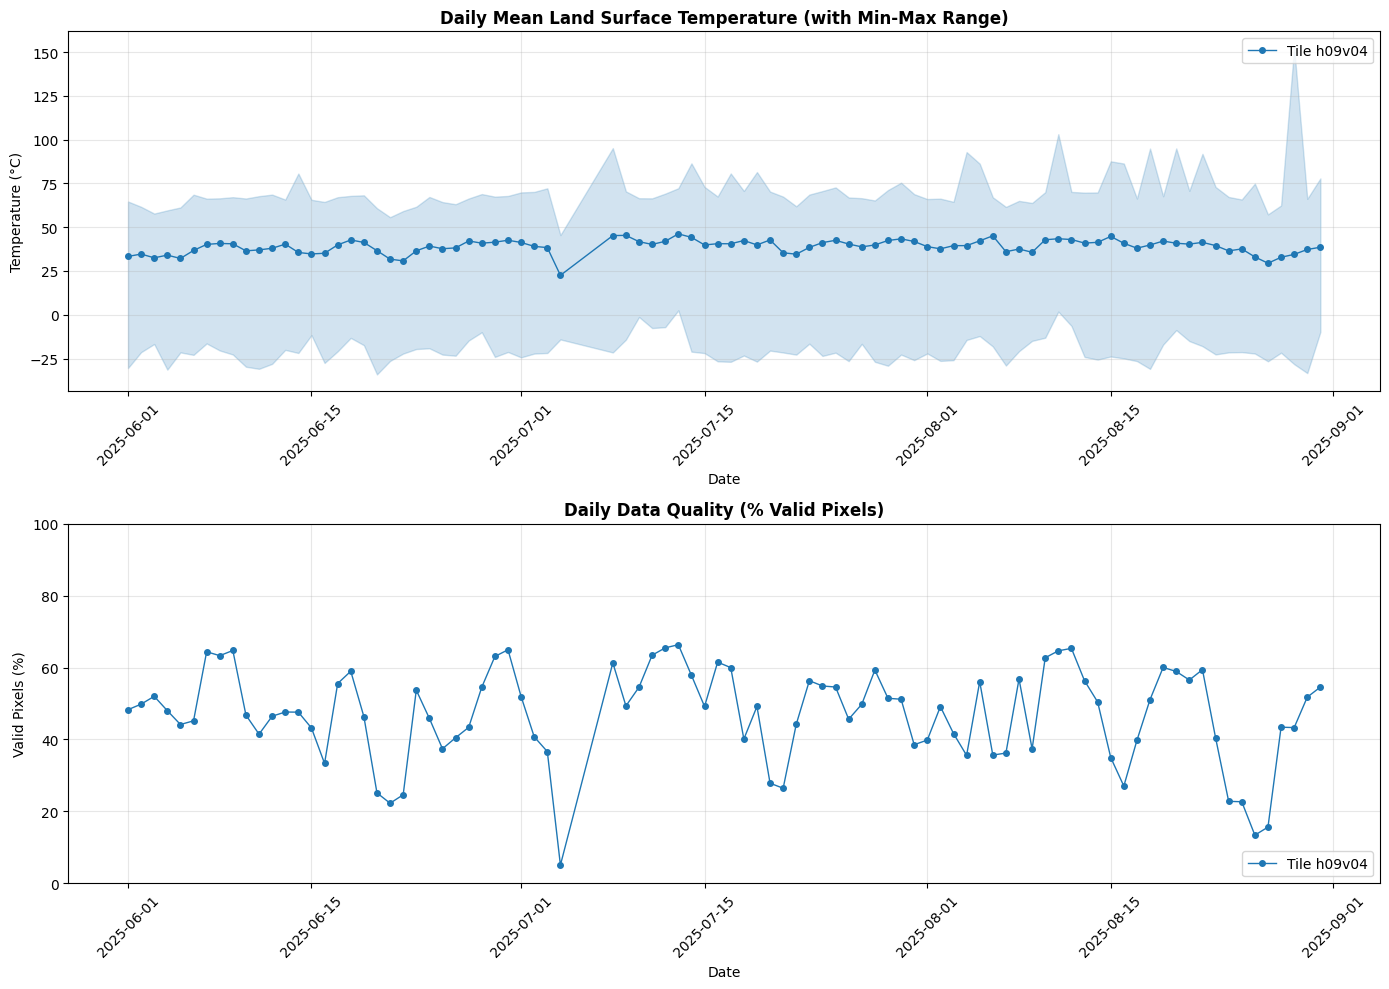


Figure saved as 'lst_time_series.png'


In [13]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Group by tile for separate plotting
tiles = df_stats['tile'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(tiles)))

# Mean temperature time series
ax1 = axes[0]
for tile, color in zip(tiles, colors):
    tile_data = df_stats[df_stats['tile'] == tile]
    ax1.plot(tile_data['date'], tile_data['mean'], 'o-', color=color, 
             label=f'Tile {tile}', markersize=4, linewidth=1)
    ax1.fill_between(tile_data['date'], tile_data['min'], tile_data['max'], 
                     alpha=0.2, color=color)

ax1.set_title('Daily Mean Land Surface Temperature (with Min-Max Range)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Data quality over time
ax2 = axes[1]
for tile, color in zip(tiles, colors):
    tile_data = df_stats[df_stats['tile'] == tile]
    ax2.plot(tile_data['date'], tile_data['valid_percent'], 'o-', color=color, 
             label=f'Tile {tile}', markersize=4, linewidth=1)

ax2.set_title('Daily Data Quality (% Valid Pixels)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Valid Pixels (%)')
ax2.set_ylim(0, 100)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('lst_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'lst_time_series.png'")

## QC (Quality Control) Data

QC flags provide pixel-level quality assessments. The decode_qc_flags() function below extracts the Mandatory QA information stored in bits 0-1 of each QC byte using a bitwise AND operation with the binary mask 0b11 (decimal 3), which isolates only the two least significant bits. These two bits encode four quality levels: 00=Good, 01=Marginal, 10=Bad, and 11=Fill/No Data.

In [14]:
def load_qc_data(file_path: str) -> np.ndarray:
    """
    Load Quality Control (QC) flags from a VIIRS HDF5 file. QC flags contain
    bit-encoded information about the reliability of each LST pixel.
    """
    with h5py.File(file_path, 'r') as f:
        qc_path = 'HDFEOS/GRIDS/VIIRS_Grid_Daily_1km_LST21/Data Fields/QC'
        qc_data = f[qc_path][:]
        
    return qc_data

def decode_qc_flags(qc_value: int) -> int:
    """
    Decode the Mandatory QA bits (bits 0-1) from a QC flag value.
    Returns: 0=Good, 1=Marginal, 2=Bad, 3=Fill/No Data.
    """
    # Bitwise AND with 0b11 (binary 11 = decimal 3) extracts only bits 0-1
    mandatory_qa = qc_value & 0b11
    return mandatory_qa

qc_data = load_qc_data(h5_files[0])
qc_decoded = np.vectorize(decode_qc_flags)(qc_data)
unique, counts = np.unique(qc_decoded, return_counts=True)
qc_labels = {0: 'Good', 1: 'Marginal', 2: 'Bad', 3: 'Fill/No Data'}

print(f"\n{'QC Level':<15} {'Count':>12} {'Percentage':>12}")
print("-" * 45)
total = qc_decoded.size
for val, count in zip(unique, counts):
    label = qc_labels.get(val, f'Unknown ({val})')
    pct = 100 * count / total
    print(f"{label:<15} {count:>12,} {pct:>11.2f}%")


QC Level               Count   Percentage
---------------------------------------------
Good                 516,004       35.83%
Marginal             179,389       12.46%
Bad                  290,631       20.18%
Fill/No Data         453,976       31.53%


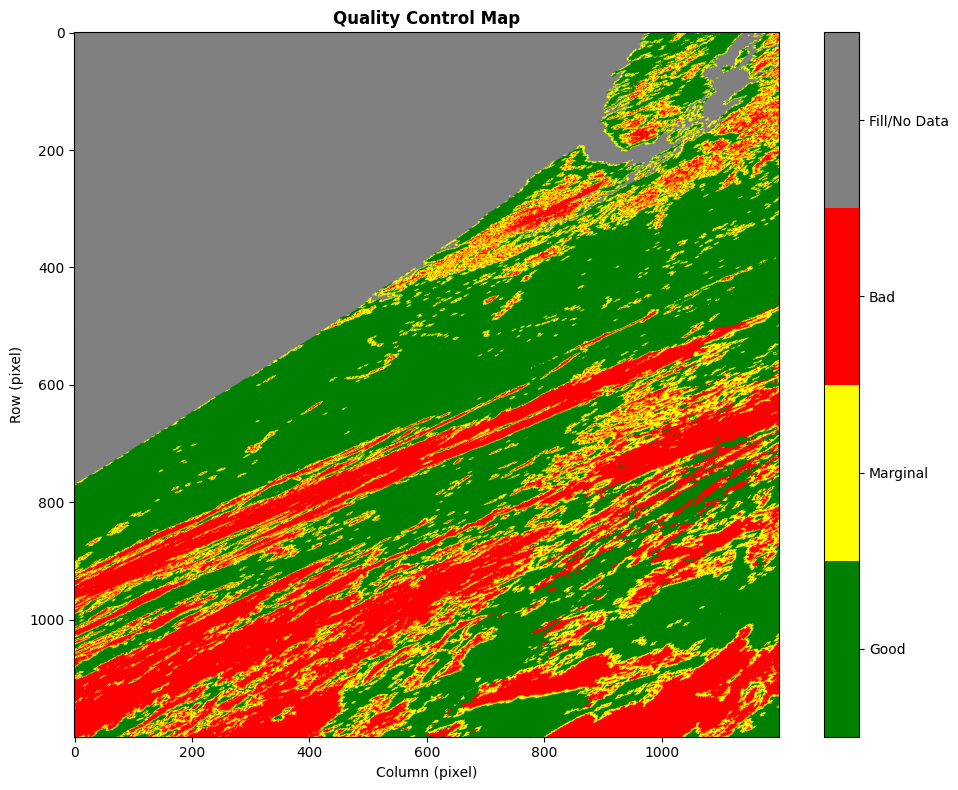

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
qc_cmap = ListedColormap(['green', 'yellow', 'red', 'gray'])
im = ax.imshow(qc_decoded, cmap=qc_cmap, vmin=0, vmax=3)
ax.set_title('Quality Control Map', fontsize=12, fontweight='bold')
ax.set_xlabel('Column (pixel)')
ax.set_ylabel('Row (pixel)')

# Colorbar with labels
cbar = plt.colorbar(im, ax=ax, ticks=[0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(['Good', 'Marginal', 'Bad', 'Fill/No Data'])

plt.tight_layout()
plt.savefig('lst_quality_map.png', dpi=150, bbox_inches='tight')
plt.show()

Now to prep the data for OpenCV analytics to get a deeper level of understanding. OpenCV annoyingly defaults to BGR instead of normal RGB, so any color images will need to be transformed first.

In [16]:
def lst_to_opencv_image(
    lst_data: MaskedArray,
    temp_min: float = 0,
    temp_max: float = 50
) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert LST data to OpenCV-compatible 8-bit images. Transforms a masked
    temperature array into grayscale and color-mapped images for visualization.
    """
    # Replace masked (invalid) values with temp_min for processing
    lst_filled = lst_data.filled(temp_min)
    
    # Clip temperature values to the valid range
    lst_clipped = np.clip(lst_filled, temp_min, temp_max)
    
    # Normalize temperatures to [0, 1] range, then scale to [0, 255]
    lst_normalized = (lst_clipped - temp_min) / (temp_max - temp_min)
    img_8bit = (lst_normalized * 255).astype(np.uint8) 
    img_color = cv2.applyColorMap(img_8bit, cv2.COLORMAP_JET)
    
    # Create a 3-channel mask by stacking the 2D mask along the color axis
    mask_3d = np.stack([lst_data.mask] * 3, axis=-1)
    img_color[mask_3d] = 0 # set masked pixels to black (0)
    
    return img_8bit, img_color

lst_data, metadata = load_lst_data(h5_files[0])
img_8bit, img_color = lst_to_opencv_image(lst_data)

print(f"\nGrayscale image shape: {img_8bit.shape}")
print(f"Grayscale dtype: {img_8bit.dtype}")
print(f"Color image shape: {img_color.shape}")
print(f"Color dtype: {img_color.dtype}")

cv2.imwrite('lst_grayscale.png', img_8bit)
cv2.imwrite('lst_colormap.png', img_color)
print(f"\nSaved: lst_grayscale.png")
print(f"Saved: lst_colormap.png")


Grayscale image shape: (1200, 1200)
Grayscale dtype: uint8
Color image shape: (1200, 1200, 3)
Color dtype: uint8

Saved: lst_grayscale.png
Saved: lst_colormap.png


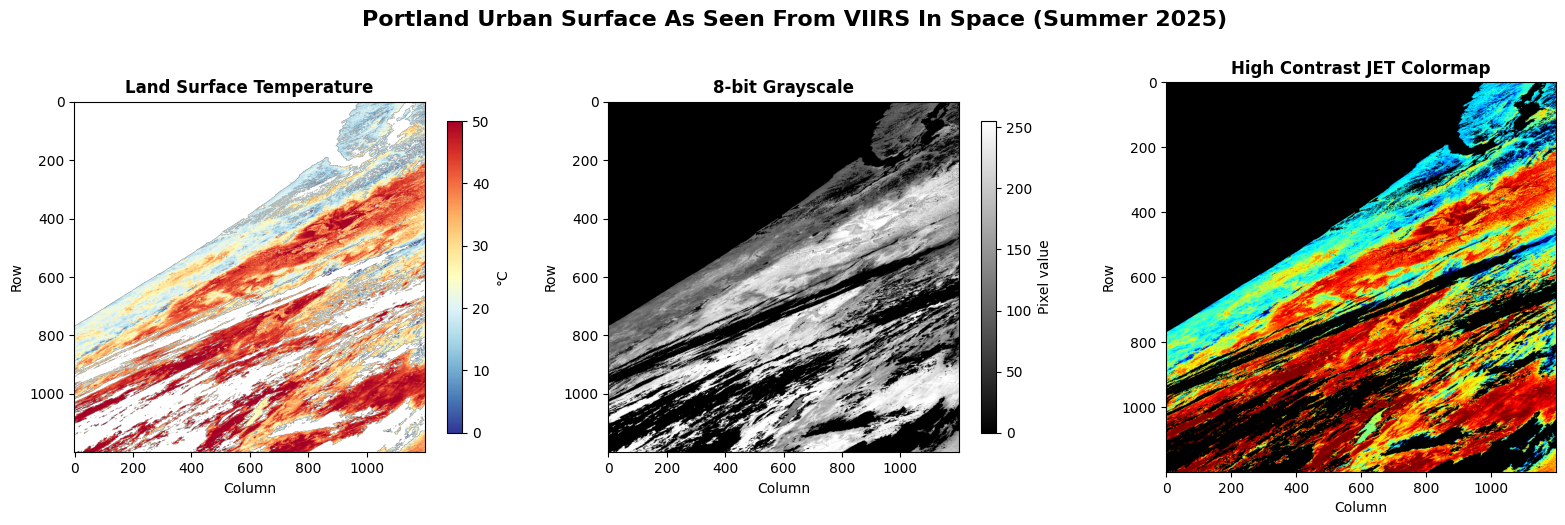

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

fig.suptitle('Portland Urban Surface As Seen From VIIRS In Space (Summer 2025)', 
             fontsize=16, fontweight='bold', y=1.02)

# Original LST
ax1 = axes[0]
im1 = ax1.imshow(lst_data, cmap='RdYlBu_r', vmin=0, vmax=50)
ax1.set_title('Land Surface Temperature', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax1, shrink=0.8, label='°C')

# 8-bit grayscale (used for computer vision techniques)
ax2 = axes[1]
im2 = ax2.imshow(img_8bit, cmap='gray', vmin=0, vmax=255)
ax2.set_title('8-bit Grayscale', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax2, shrink=0.8, label='Pixel value')

# Color mapped (OpenCV JET)
ax3 = axes[2]
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
ax3.imshow(img_rgb)
ax3.set_title('High Contrast JET Colormap', fontsize=12, fontweight='bold')

for ax in axes:
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

plt.tight_layout()
plt.savefig('lst_opencv_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

<h2 style="text-align: center">Deeper Analysis</h2>

To dive deeper into more detail, a full custom suite was created in the adjacent python script for quick and easy implementation into this notebook so that this can be more focussed on the outputs, rather than the code.

In [18]:
analyzer = PortlandHeatAnalyzer()
print(f" Analyzer initialized with {len(analyzer.zones)} zones")
print(f" Available zones: {list(analyzer.zones.keys())}")

 Analyzer initialized with 6 zones
 Available zones: ['urban_core', 'suburban', 'forest_park', 'rural', 'mountain', 'river_adjacent']


## Urban Heat Island Intensity (UHII)

UHII is a quantitative measure of the temperature difference between urban areas and their surrounding rural or non-urbanized regions, typically expressed in degrees Celsius or Fahrenheit. This phenomenon occurs because cities contain large amounts of heat-absorbing materials like asphalt, concrete, and buildings, combined with reduced vegetation and waste heat from human activities such as air conditioning and vehicles. UHII is critically important for public health planning because elevated urban temperatures increase heat-related illnesses, mortality rates, and energy consumption for cooling, with these effects disproportionately impacting vulnerable populations such as the elderly and low-income communities. Understanding and monitoring UHII through satellite-derived Land Surface Temperature data enables urban planners to implement targeted mitigation strategies like expanding green spaces, installing cool roofs, and increasing tree canopy coverage in the most affected neighborhoods.

In [19]:
zone_stats = analyzer.zone_statistics(lst_data)
zone_stats = zone_stats.sort_values('mean', ascending=False)
print("\nTemperature by Zone:")
print(zone_stats.to_string(index=False))

uhii = analyzer.calculate_uhii(lst_data, 'urban_core', 'rural')
print(f"\n Urban Heat Island Intensity: {uhii:.2f}°C")


Temperature by Zone:
          zone      mean       std    min   max   p25   p50    p75  n_pixels
river_adjacent 27.586849 18.139960 -13.13 57.03  0.00 34.13 42.930     76000
    urban_core 24.487621 20.143871 -13.13 61.59  0.00 31.05 42.575     90000
      mountain 24.434532 15.935286 -23.33 59.17 13.29 26.95 37.450    200000
         rural 24.265271 18.423370 -24.21 61.45  0.00 30.07 39.490    160000
      suburban 19.995559 18.980356   0.00 63.37  0.00 20.65 38.410    160000
   forest_park 19.864291 10.113142   0.00 48.13 17.41 21.25 26.310     20000

 Urban Heat Island Intensity: 2.82°C


In [20]:
uhii_series = []
dates = []

print("\nProcessing all files...")
for i, filepath in enumerate(h5_files):
    if i % 10 == 0:
        print(f"  {i+1}/{len(h5_files)}...")
    
    try:
        result = load_lst_data(filepath)
        lst = result[0] if isinstance(result, tuple) else result
        
        # Convert MaskedArray to regular array
        if hasattr(lst, 'filled'):
            lst = lst.filled(np.nan)
        
        file_info = parse_viirs_filename(filepath.name)
        uhii_val = analyzer.calculate_uhii(lst, 'urban_core', 'rural')
        
        if not np.isnan(uhii_val):
            uhii_series.append(float(uhii_val))
            dates.append(file_info['acquisition_date'])
    except Exception as e:
        if i < 3:
            print(f"    Error: {e}")
        continue

print(f"\nCollected {len(uhii_series)} valid UHII values")

if len(uhii_series) > 0:
    df_uhii = pd.DataFrame({'date': dates, 'uhii': uhii_series})
    
    print(f"\nUHII Statistics:")
    print(f"  Mean:     {df_uhii['uhii'].mean():.2f}°C")
    print(f"  Max:      {df_uhii['uhii'].max():.2f}°C (on {df_uhii.loc[df_uhii['uhii'].idxmax(), 'date'].strftime('%Y-%m-%d')})")
    print(f"  Min:      {df_uhii['uhii'].min():.2f}°C")
    print(f"  Std Dev:  {df_uhii['uhii'].std():.2f}°C")
    
    df_uhii.to_csv('portland_uhii_time_series.csv', index=False)
    print("\nSaved: portland_uhii_time_series.csv")


Processing all files...
  1/89...
  11/89...
  21/89...
  31/89...
  41/89...
  51/89...
  61/89...
  71/89...
  81/89...

Collected 88 valid UHII values

UHII Statistics:
  Mean:     2.99°C
  Max:      9.58°C (on 2025-07-12)
  Min:      -10.00°C
  Std Dev:  3.52°C

Saved: portland_uhii_time_series.csv


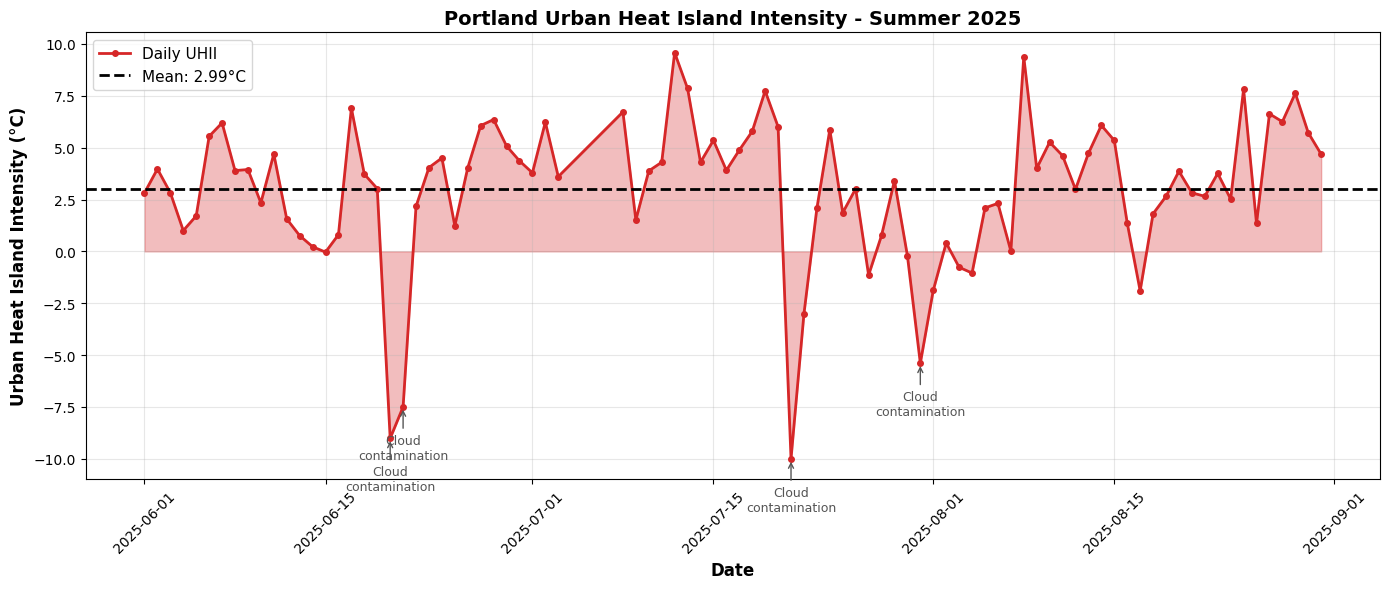

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_uhii['date'], df_uhii['uhii'], marker='o', linewidth=2, 
        markersize=4, color='#d62728', label='Daily UHII')

# Add horizontal line showing mean UHII across the time period
ax.axhline(df_uhii['uhii'].mean(), color='black', linestyle='--', 
           linewidth=2, label=f'Mean: {df_uhii["uhii"].mean():.2f}°C')

# Add shaded fill between zero and UHII values
ax.fill_between(df_uhii['date'], 0, df_uhii['uhii'], alpha=0.3, color='#d62728')

# Identify significant dips (due to cloud contamination)
dip_threshold: float = -5.0
dip_mask: pd.Series = df_uhii['uhii'] < dip_threshold
dip_dates = df_uhii.loc[dip_mask, 'date']
dip_values = df_uhii.loc[dip_mask, 'uhii']

for date, value in zip(dip_dates, dip_values):
    ax.annotate(
        'Cloud\ncontamination',
        xy=(date, value),
        xytext=(date, value - 2.5),
        fontsize=9,
        ha='center',
        color='#555555',
        arrowprops=dict(arrowstyle='->', color='#555555', lw=1)
    )

ax.set_xlabel('Date', fontweight='bold', fontsize=12)
ax.set_ylabel('Urban Heat Island Intensity (°C)', fontweight='bold', fontsize=12)
ax.set_title('Portland Urban Heat Island Intensity - Summer 2025', 
             fontweight='bold', fontsize=14)
ax.grid(alpha=0.3)
ax.legend(fontsize=11)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('uhii_time_series.png', dpi=200, bbox_inches='tight')
plt.show()

## Hot Spot Detection

In [22]:
# Detect hot spots (>90th percentile)
hot_spots = analyzer.detect_hot_spots(lst_data, threshold_percentile=90)
n_hot_spots = np.sum(hot_spots)

print(f"Hot spots detected: {n_hot_spots:,} pixels ({(n_hot_spots/(1200*1200))*100:.1f}% of area)")
print("\nHot Spot Concentration by Zone:")
for zone_name, zone_mask in analyzer.zones.items():
    zone_hot = np.sum(hot_spots & zone_mask)
    zone_total = np.sum(zone_mask)
    if zone_total > 0:
        pct = (zone_hot / zone_total) * 100
        print(f"  {zone_name:15s}: {pct:5.1f}% of zone is a hot spot")

Hot spots detected: 144,431 pixels (10.0% of area)

Hot Spot Concentration by Zone:
  urban_core     :  19.6% of zone is a hot spot
  suburban       :  13.1% of zone is a hot spot
  forest_park    :   0.0% of zone is a hot spot
  rural          :  13.6% of zone is a hot spot
  mountain       :   8.8% of zone is a hot spot
  river_adjacent :  18.9% of zone is a hot spot


In [23]:
# Load every 3rd day to save memory
lst_series = []
print("\nLoading every 3rd file...")
for i in range(0, len(h5_files), 3):
    try:
        result = load_lst_data(h5_files[i])
        lst = result[0] if isinstance(result, tuple) else result
        
        # Convert MaskedArray to regular array
        if hasattr(lst, 'filled'):
            lst = lst.filled(np.nan)
        
        lst_series.append(lst)
    except:
        continue

print(f"Loaded {len(lst_series)} days")

# Analyze persistence
persistence = analyzer.persistent_heat_analysis(lst_series, persistence_days=5)

print(f"\nPersistent Hot Spots (hot >=5 days):")
print(f"  Total pixels: {persistence['n_persistent_pixels']:,}")
print(f"  % of area:    {(persistence['n_persistent_pixels']/(1200*1200))*100:.1f}%")

# By zone
print(f"\nPersistent Heat by Zone:")
for zone_name, zone_mask in analyzer.zones.items():
    zone_persist = np.sum(persistence['persistent_hot_spots'] & zone_mask)
    zone_total = np.sum(zone_mask)
    if zone_total > 0:
        pct = (zone_persist / zone_total) * 100
        print(f"  {zone_name:15s}: {pct:5.1f}%")


Loading every 3rd file...
Loaded 30 days

Persistent Hot Spots (hot >=5 days):
  Total pixels: 145,800
  % of area:    10.1%

Persistent Heat by Zone:
  urban_core     :  19.6%
  suburban       :  19.6%
  forest_park    :   1.4%
  rural          :  18.3%
  mountain       :   6.5%
  river_adjacent :  17.5%


In [24]:
# Set urban center point (approximate Portland downtown)
urban_center = (850, 350)  # (row, col)

gradient_df = analyzer.temperature_gradient_analysis(lst_data, urban_center, max_radius=400)

print("\nTemperature vs Distance from Urban Core:")
print(gradient_df[['distance_km', 'mean_temp', 'n_pixels']].head(10).to_string(index=False))

# Find cooling distance
urban_temp = gradient_df.iloc[0]['mean_temp']
cooling_target = urban_temp - 5  # 5°C cooler

cooling_dist = None
for _, row in gradient_df.iterrows():
    if row['mean_temp'] <= cooling_target:
        cooling_dist = row['distance_km']
        break

if cooling_dist:
    print(f"\n  Cooling Distance: {cooling_dist:.0f} km")
    print(f"   (Distance to find areas 5°C cooler than urban center)")

gradient_df.to_csv('temperature_gradient.csv', index=False)


Temperature vs Distance from Urban Core:
 distance_km  mean_temp  n_pixels
           0  32.638264       305
          10  33.202829       940
          20  36.176425      1564
          30  38.336325      2204
          40  42.447360      2812
          50  44.533233      3452
          60  44.211035      4084
          70  43.222174      4708
          80  41.376597      5364
          90  41.299597      5964


In [25]:
# This creates a multi-panel figure with all analyses
zone_stats_viz = create_comparison_visualizations(analyzer, lst_data, 'portland_uhi')

## Heat Wave Detection

In [26]:
heat_waves = analyzer.heat_wave_detection(df_stats, threshold_temp=40.0, min_duration=3)

if len(heat_waves) > 0:
    print(f"\nDetected {len(heat_waves)} heat wave event(s):\n")
    for i, hw in heat_waves.iterrows():
        print(f"Event {i+1}:")
        print(f"  {hw['start_date'].strftime('%Y-%m-%d')} to {hw['end_date'].strftime('%Y-%m-%d')}")
        print(f"  Duration: {hw['duration_days']} days")
        print(f"  Peak: {hw['max_temp']:.1f}°C, Avg: {hw['avg_temp']:.1f}°C\n")
    
    heat_waves.to_csv('heat_waves.csv', index=False)
    print("✓ Saved: heat_waves.csv")
else:
    print("\nNo heat waves detected (no 3+ day periods above 40°C)")


Detected 8 heat wave event(s):

Event 1:
  2025-06-07 to 2025-06-09
  Duration: 3 days
  Peak: 40.7°C, Avg: 40.5°C

Event 2:
  2025-06-27 to 2025-07-01
  Duration: 5 days
  Peak: 42.5°C, Avg: 41.7°C

Event 3:
  2025-07-08 to 2025-07-14
  Duration: 7 days
  Peak: 46.2°C, Avg: 43.5°C

Event 4:
  2025-07-16 to 2025-07-18
  Duration: 3 days
  Peak: 42.4°C, Avg: 41.2°C

Event 5:
  2025-07-24 to 2025-07-26
  Duration: 3 days
  Peak: 42.5°C, Avg: 41.4°C

Event 6:
  2025-07-29 to 2025-07-31
  Duration: 3 days
  Peak: 43.3°C, Avg: 42.5°C

Event 7:
  2025-08-10 to 2025-08-16
  Duration: 7 days
  Peak: 44.7°C, Avg: 42.4°C

Event 8:
  2025-08-19 to 2025-08-22
  Duration: 4 days
  Peak: 42.1°C, Avg: 41.2°C

✓ Saved: heat_waves.csv
